In [1]:
!pip install ultralytics boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.3 MB/s eta 0:00:00


In [2]:
import boto3
import botocore
from botocore.exceptions import ClientError
import os
from google.colab import userdata


os.environ['AWS_ACCESS_KEY_ID'] = userdata.get("AWS_ACCESS_KEY_ID")
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get("AWS_SECRET_ACCESS_KEY")
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

In [3]:
s3 = boto3.resource('s3')
BUCKET = "sjsu-fall24-data298-team6-bucket"
KEY = 'runs/yolo.zip'
try:
    s3.Bucket(BUCKET).download_file(KEY, 'model.zip')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise
!unzip -q model.zip -d model

In [4]:
KEY = 'dataset/yolo.zip'
try:
    s3.Bucket(BUCKET).download_file(KEY, 'data.zip')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise
!unzip -q data.zip -d data

In [5]:
from ultralytics import YOLO
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
test_image = "/content/data/test/images/0000002_00005_d_0000014.jpg"
test_label = "/content/data/test/labels/0000002_00005_d_0000014.txt"

In [8]:
test_bbox = []
with open(test_label, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)
        x_min = (x_center - width / 2)
        y_min = (y_center - height / 2)
        x_max = (x_center + width / 2)
        y_max = (y_center + height / 2)
        test_bbox.append([x_min, y_min, x_max, y_max])

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
def draw_image_with_bbox(image_path, bbox, title, scale=False):
    img = Image.open(image_path)
    plt.imshow(img)
    for box in bbox:
        x_min, y_min, x_max, y_max = box
        if scale:
            x_min, x_max = img.size[0] * x_min, img.size[0] * x_max
            y_min, y_max = img.size[1] * y_min, img.size[1] * y_max
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    plt.axis('off')
    plt.title(title)
    plt.show()

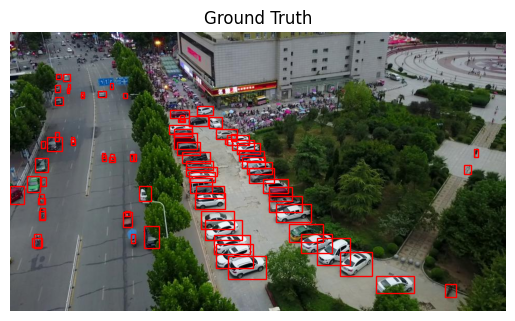

In [10]:
draw_image_with_bbox(test_image, test_bbox, "Ground Truth", scale=True)

100%|██████████| 5.35M/5.35M [00:00<00:00, 332MB/s]



image 1/1 /content/data/test/images/0000002_00005_d_0000014.jpg: 384x640 8 cars, 107.8ms
Speed: 12.8ms preprocess, 107.8ms inference, 803.7ms postprocess per image at shape (1, 3, 384, 640)


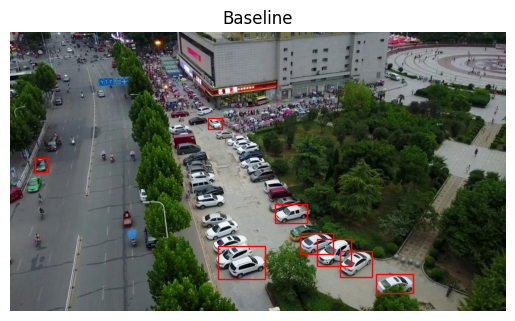

In [11]:
model = YOLO("yolo11n.pt")
base_pred = model.predict(source=test_image, conf=0.35)
base_bbox = base_pred[0].boxes.xyxy.tolist()
draw_image_with_bbox(test_image, base_bbox, "Baseline")


image 1/1 /content/data/test/images/0000002_00005_d_0000014.jpg: 384x640 1 pedestrian, 3 peoples, 50 cars, 5 vans, 1 truck, 1 tricycle, 1 awning-tricycle, 1 motor, 14.8ms
Speed: 2.5ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


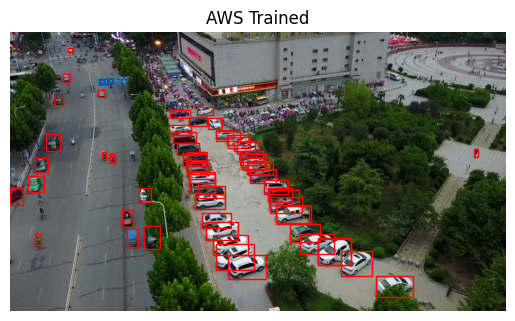

In [12]:
model = YOLO("/content/model/detect/train/weights/best.pt")
awsm_pred = model.predict(source=test_image, conf=0.35)
awsm_bbox = awsm_pred[0].boxes.xyxy.tolist()
draw_image_with_bbox(test_image, awsm_bbox, "AWS Trained")

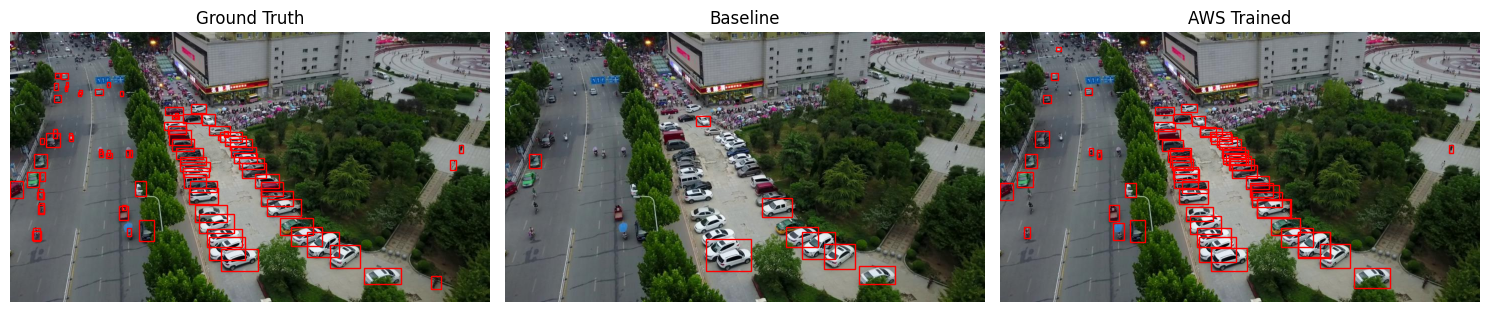

In [15]:
img = Image.open(test_image)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Ground Truth")
ax[1].imshow(img)
ax[1].set_title("Baseline")
ax[2].imshow(img)
ax[2].set_title("AWS Trained")
for box in test_bbox:
    x_min, y_min, x_max, y_max = box
    x_min, x_max = img.size[0] * x_min, img.size[0] * x_max
    y_min, y_max = img.size[1] * y_min, img.size[1] * y_max
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

for box in base_bbox:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

for box in awsm_bbox:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()